# 데이터 EDA 분석

In [ ]:
import tensorflow as tf 
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = './data/train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images
        label = filename.split('\\')[-1] #get label
        training_labels.append(label) #append label
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [ ]:
#create test dataset

path = './data/test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    label = filename.split('\\')[-1] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


[0],[0],[1],[1],[2],[2],[3],[3],[4],[4],[5],[5],[6],[6],[7],[7],[8],[8],[9],[9],

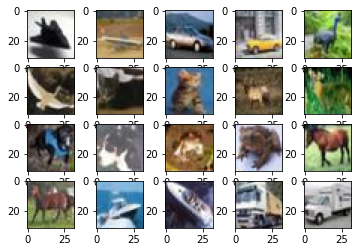

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(training_images[i*2500])
    print(training_labels[i*2500], end=",")
plt.show()

In [ ]:
label_num = [0,1,2,3,4,5,6,7,8,9]
label_name = le.inverse_transform(label_num)

for i in range(10):
    print(label_num[i], label_name[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


# 데이터 증식

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

tf.random.set_seed(42)

image_generator = ImageDataGenerator(
    rotation_range=30,
    brightness_range = [0.8, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

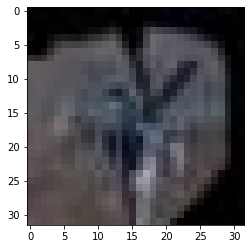

In [ ]:
sample_image = training_images[2]
plt.imshow(sample_image.astype('uint8'))
sample_image = np.expand_dims(sample_image, 0)

In [ ]:
sample_image_it = image_generator.flow(sample_image, batch_size=2, seed = 42)

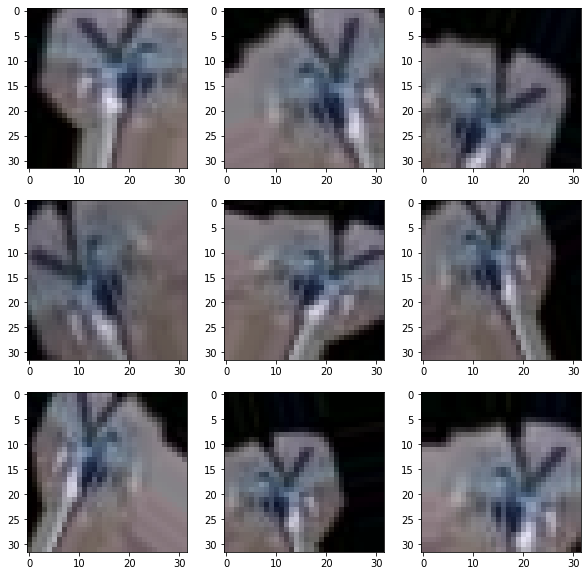

In [ ]:
fig = plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3, 3, 1+i)
    batch = sample_image_it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [ ]:
augment_size=150000

np.random.seed(42)

random_mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image_aug = training_images[random_mask].copy()
training_labels_aug = training_labels[random_mask].copy()

In [ ]:
training_image_aug = image_generator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False, seed = 42).next()[0]

training_images = np.concatenate((training_images, training_image_aug))
training_labels = np.concatenate((training_labels, training_labels_aug))

In [ ]:
print(training_images.shape)
print(training_labels.shape)

(200000, 32, 32, 3)
(200000, 1)


## mixup augmentation

tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


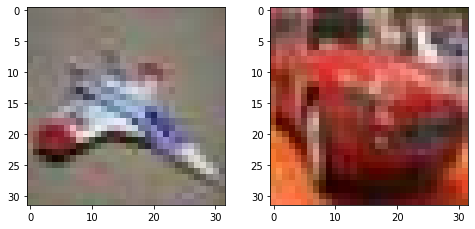

In [ ]:
import tensorflow as tf

sample_image = training_images[1]
sample_label = tf.one_hot(training_labels[1], 10) # one hot encoding을 진행해야 mixup을 할 수 있습니다.

sample_image2 = training_images[5001]
sample_label2 = tf.one_hot(training_labels[5001], 10)

fig = plt.figure(figsize = (8,8))

plt.subplot(2, 2, 1)
plt.imshow(sample_image.astype('uint8'))
print(sample_label)

plt.subplot(2, 2, 2)
plt.imshow(sample_image2.astype('uint8'))
print(sample_label2)
    
plt.show()

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, batch_size = 1, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.3837844729423523, 0.6162155270576477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0010585743002593517, 0.9989414215087891, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.5299530625343323, 0.4700469374656677, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.4734334647655487, 0.5265665054321289, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.29447418451309204, 0.705525815486908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.871533215045929, 0.12846678495407104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.33716145157814026, 0.6628385782241821, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9136892557144165, 0.0863107442855835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.2452724128961563, 0.7547276020050049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


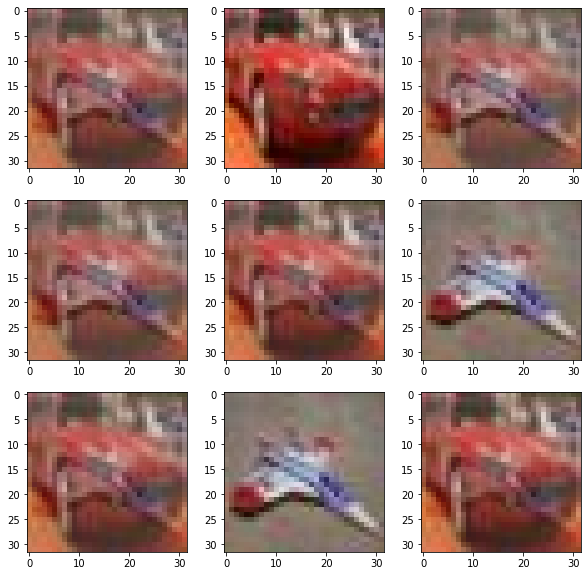

In [ ]:
mix_image, mix_label = mix_up((sample_image, sample_label), (sample_image2, sample_label2), batch_size = 9, alpha = 0.5)

fig = plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3, 3, 1+i)
    image = mix_image[i]
    plt.imshow(image.numpy().squeeze().astype('uint8'))
    print(mix_label[i].numpy().tolist())

In [ ]:
import random
random.seed(42)
from sys import stdout

training_labels = tf.one_hot(training_labels, 10) #mixup을 적용하기 위해 one-hot 기법을 적용해줍니다

mix_training_images = []
mix_training_labels = []

for i in range(3):
    random_num = random.sample(range(0,50000), 50000) #augmentation을 적용한 데이터를 제외하고 mix해보겠습니다
    print("\nAttempt", i)
    progress_before = 0

    for i in range(0,50000,2):
        image_1 = training_images[random_num[i]]
        label_1 = training_labels[random_num[i]]

        image_2 = training_images[random_num[i+1]]
        label_2 = training_labels[random_num[i+1]]

        mix_image, mix_label = mix_up((image_1, label_1), (image_2, label_2))

        mix_training_images.append(mix_image[0])
        mix_training_labels.append(mix_label[0])
        
        #just for ui
        progress = int(100*(i/49998))
        if progress != progress_before:
            progress_before = progress
            stdout.write("\r ========= %d%% completed =========" %progress)
            stdout.flush()

mix_training_images = np.array(mix_training_images)
mix_training_labels = np.array(mix_training_labels)


Attempt 0
 ========= 100% completed =========
Attempt 1
 ========= 100% completed =========
Attempt 2
 ========= 100% completed =========

In [ ]:
print('mix_train 크기:',mix_training_images.shape)
print('mix_label 크기:',mix_training_labels.shape)

mix_train 크기: (75000, 32, 32, 3)
mix_label 크기: (75000, 10)


## Data set 나누기

In [ ]:
from sklearn.model_selection import train_test_split

training_labels = np.array(training_labels)
training_labels = training_labels.reshape(-1,10) #mixup에서 one-hot 기법을 적용했다면, shape을 바꿔줍니다.

X_train, X_valid, y_train, y_valid = train_test_split(training_images, 
                                                      training_labels, 
                                                      test_size=0.05, 
                                                      stratify = training_labels, 
                                                      random_state=42)

X_train = np.concatenate((X_train, mix_training_images)) #mixup한 75000개의 데이터를 train set에 추가해줍니다
y_train = np.concatenate((y_train, mix_training_labels))

X_test = test_images

In [ ]:
print('X_train 크기:',X_train.shape)
print('y_train 크기:',y_train.shape)
print('X_valid 크기:',X_valid.shape)
print('y_valid 크기:',y_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (265000, 32, 32, 3)
y_train 크기: (265000, 10)
X_valid 크기: (10000, 32, 32, 3)
y_valid 크기: (10000, 10)
X_test  크기: (10000, 32, 32, 3)


In [ ]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

## 모델 생성

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 64)       2

## 모델 학습

### epoch 20


In [ ]:
EPOCH = 20
BATCH_SIZE = 128

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5 Epoch동안 개선되지 않는다면 종료
                             )

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
)

In [ ]:
data = model.fit(X_train, 
                 y_train, 
                 validation_data=(X_valid, y_valid), 
                 epochs=EPOCH, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[reduceLR, earlystopping],)

Epoch 1/20
2071/2071 [==============================] - 99s 44ms/step - loss: 1.6328 - accuracy: 0.4363 - val_loss: 1.3448 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 2/20
2071/2071 [==============================] - 88s 42ms/step - loss: 1.1011 - accuracy: 0.6739 - val_loss: 1.0136 - val_accuracy: 0.6634 - lr: 0.0010
Epoch 3/20
2071/2071 [==============================] - 86s 42ms/step - loss: 0.8739 - accuracy: 0.7584 - val_loss: 0.7673 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 4/20
2071/2071 [==============================] - 86s 41ms/step - loss: 0.7255 - accuracy: 0.8104 - val_loss: 0.7079 - val_accuracy: 0.7711 - lr: 0.0010
Epoch 5/20
2071/2071 [==============================] - 85s 41ms/step - loss: 0.6199 - accuracy: 0.8457 - val_loss: 0.6011 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 6/20
2071/2071 [==============================] - 85s 41ms/step - loss: 0.5375 - accuracy: 0.8728 - val_loss: 0.5576 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 7/20
2071/2071 [========================

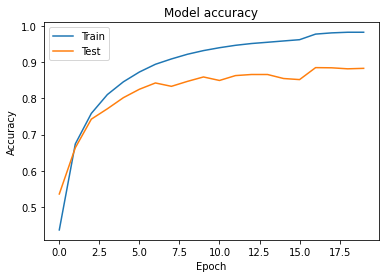

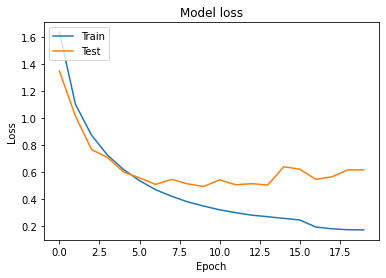

In [ ]:
import matplotlib.pyplot as plot

plot.plot(data.history['accuracy'])
plot.plot(data.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(data.history['loss'])
plot.plot(data.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

### epoch 40


In [ ]:
EPOCH = 40
BATCH_SIZE = 128

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5 Epoch동안 개선되지 않는다면 종료
                             )

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
)

In [ ]:
data = model.fit(X_train, 
                 y_train, 
                 validation_data=(X_valid, y_valid), 
                 epochs=EPOCH, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[reduceLR, earlystopping],)

Epoch 1/40
2071/2071 [==============================] - 91s 44ms/step - loss: 1.5894 - accuracy: 0.4553 - val_loss: 1.1552 - val_accuracy: 0.5921 - lr: 0.0010
Epoch 2/40
2071/2071 [==============================] - 92s 44ms/step - loss: 1.0728 - accuracy: 0.6849 - val_loss: 0.8622 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 3/40
2071/2071 [==============================] - 91s 44ms/step - loss: 0.8532 - accuracy: 0.7660 - val_loss: 0.7471 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 4/40
2071/2071 [==============================] - 112s 54ms/step - loss: 0.7080 - accuracy: 0.8152 - val_loss: 0.5835 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 5/40
2071/2071 [==============================] - 104s 50ms/step - loss: 0.6060 - accuracy: 0.8494 - val_loss: 0.5885 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 6/40
2071/2071 [==============================] - 120s 58ms/step - loss: 0.5242 - accuracy: 0.8766 - val_loss: 0.5335 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 7/40
2071/2071 [=====================

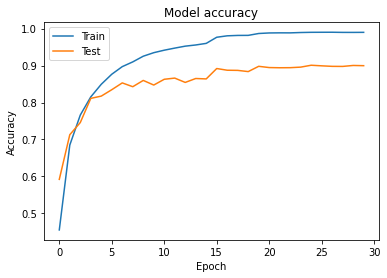

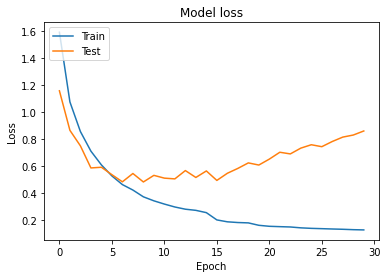

In [ ]:
import matplotlib.pyplot as plot

plot.plot(data.history['accuracy'])
plot.plot(data.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(data.history['loss'])
plot.plot(data.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [ ]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'horse', 'airplane'], dtype='<U10')

In [ ]:
import pandas as pd

sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit_15.csv",index=False)

In [ ]:
sample_submission.head(10)

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,airplane
3,0003.jpg,horse
4,0004.jpg,airplane
5,0005.jpg,deer
6,0006.jpg,airplane
7,0007.jpg,frog
8,0008.jpg,airplane
9,0009.jpg,deer


# Resnet50V2

In [ ]:
train_path = "C:\\Users\\chaos\\Desktop\\ds_project\\data\\train\\"

In [ ]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Hyper parameter 수정

In [ ]:
# 예측할 클래스 수
classes = 10

# Input으로 사용될 크기와 채널수
height = 256
width = 256
channels = 3

이미지 처리 진행

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)
image_data_train = image_generator.flow_from_directory(train_path,subset='training')
image_data_test = image_generator.flow_from_directory(train_path,subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
image_generator = ImageDataGenerator(
    rotation_range=30,
    brightness_range = [0.8, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

모델로드

In [ ]:
resnetv2 = tf.keras.applications.ResNet50V2(include_top=False,input_shape=(height,width,channels))

In [ ]:
resnetv2.trainable=False

기존 레이어 학습 동결 

In [ ]:
model = Sequential([
                 resnetv2,
                 Dense(512,activation='relu'),
                 BatchNormalization(),
                 GlobalAveragePooling2D(),
                 Dense(classes,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 dense (Dense)               (None, 8, 8, 512)         1049088   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,621,066
Trainable params: 1,055,242
Non

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [ ]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
hist=model.fit(image_data_train,batch_size=32,epochs=10,callbacks=[lrs],validation_data=(image_data_test),
          validation_steps =image_data_test.samples/image_data_test.batch_size)

Epoch 1/10
1250/1250 [==============================] - 101s 78ms/step - loss: 0.6656 - accuracy: 0.7690 - val_loss: 0.5548 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.4682 - accuracy: 0.8364 - val_loss: 0.5347 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 96s 77ms/step - loss: 0.3402 - accuracy: 0.8838 - val_loss: 0.5377 - val_accuracy: 0.8224 - lr: 9.0484e-04
Epoch 4/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.2220 - accuracy: 0.9259 - val_loss: 0.5579 - val_accuracy: 0.8231 - lr: 8.1873e-04
Epoch 5/10
1250/1250 [==============================] - 96s 77ms/step - loss: 0.1309 - accuracy: 0.9607 - val_loss: 0.5980 - val_accuracy: 0.8258 - lr: 7.4082e-04
Epoch 6/10
1250/1250 [==============================] - 97s 78ms/step - loss: 0.0741 - accuracy: 0.9816 - val_loss: 0.6751 - val_accuracy: 0.8186 - lr: 6.7032e-04
Epoch 7/10
1250/1250 [=======

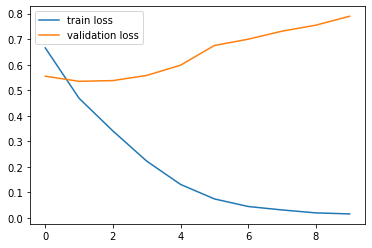

In [ ]:
plt.plot( hist.history['loss'], label='train loss')
plt.plot( hist.history['val_loss'], label='validation loss')
plt.legend()



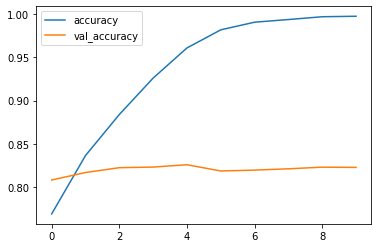

In [ ]:
plt.plot( hist.history['accuracy'], label='accuracy')
plt.plot( hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

# VGG16

In [ ]:
import os
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import seaborn as sns
import matplotlib as pl

In [ ]:

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import keras

In [ ]:
import os.path
from fastai.imports import *
import seaborn as sns
import matplotlib as pl
import pathlib



In [ ]:
import matplotlib.pyplot as plot

In [ ]:
train_dir="C:\\Users\\chaos\\Desktop\\ds_project\\data\\train\\"


In [ ]:
data_dir="C:\\Users\\chaos\\Desktop\\ds_project\\data\\"
data_dir = pathlib.Path(data_dir)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
epochs = 10

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=119,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 50000 files belonging to 10 classes.
Using 10000 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


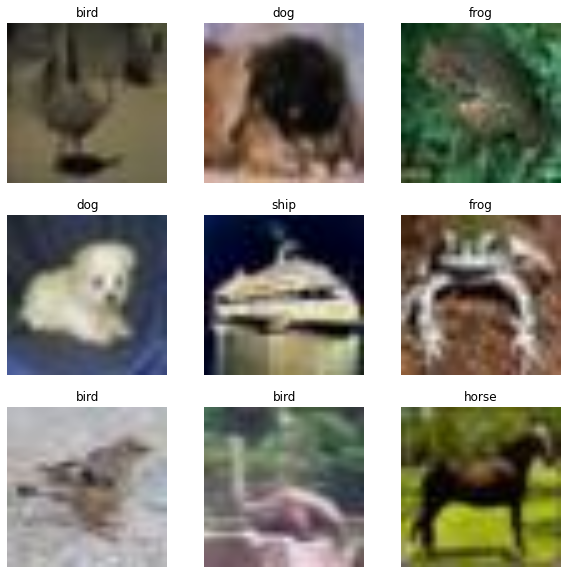

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [ ]:
img_shape = (img_height , img_width, 3)
# include_top = False인 경우 input_shape = img_size 지정 필요
# conv에 대한 가중치 학습이 없음
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

In [ ]:
VGG16_MODEL.trainable=False
# flatten이 없음 ( globalaveragepooling으로 대체 )
#  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names),
                                         activation ='softmax' )

model = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])
# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds))

Epoch 1/10
1250/1250 [==============================] - 102s 77ms/step - loss: 1.3146 - accuracy: 0.5985 - val_loss: 0.7352 - val_accuracy: 0.7344
Epoch 2/10
1250/1250 [==============================] - 98s 79ms/step - loss: 0.8618 - accuracy: 0.7092 - val_loss: 1.0995 - val_accuracy: 0.6406
Epoch 3/10
1250/1250 [==============================] - 83s 66ms/step - loss: 0.8016 - accuracy: 0.7283 - val_loss: 0.8858 - val_accuracy: 0.6562
Epoch 4/10
1250/1250 [==============================] - 93s 74ms/step - loss: 0.7773 - accuracy: 0.7373 - val_loss: 0.6224 - val_accuracy: 0.7812
Epoch 5/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.7620 - accuracy: 0.7393 - val_loss: 0.7909 - val_accuracy: 0.7031
Epoch 6/10
1250/1250 [==============================] - 89s 71ms/step - loss: 0.7603 - accuracy: 0.7390 - val_loss: 0.8761 - val_accuracy: 0.7344
Epoch 7/10
1250/1250 [==============================] - 82s 66ms/step - loss: 0.7584 - accuracy: 0.7382 - val_loss: 0.8111 

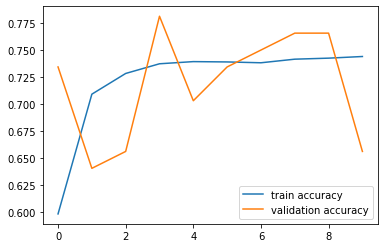

In [ ]:
plt.plot( history.history['accuracy'], label='train accuracy')
plt.plot( history.history['val_accuracy'], label='validation accuracy')
plt.legend()

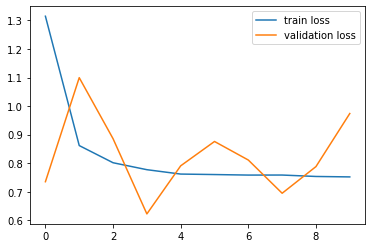

In [ ]:
plt.plot( history.history['loss'], label='train loss')
plt.plot( history.history['val_loss'], label='validation loss')
plt.legend()

# Xception

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow_hub as hub
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
directory_train = "C:\\Users\\chaos\\Desktop\\ds_project\\data\\train\\"
directory_test = "C:\\Users\\chaos\\Desktop\\ds_project\\data\\test\\"

In [ ]:
def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         validation_split=validation_split)
    return image_generator

In [ ]:
image_gen_train = get_ImageDataGenerator(validation_split=0.2)

In [ ]:

def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, 
                                                               batch_size=32, 
                                                               class_mode='categorical', 
                                                               target_size=(299,299), 
                                                               subset=train_valid, 
                                                               seed=seed)    
    return train_generator

In [ ]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
image_gen_test = get_ImageDataGenerator(validation_split=None)

In [ ]:
test_generator = get_generator(image_gen_test, directory_test, train_valid=None, seed=1)

Found 0 images belonging to 0 classes.


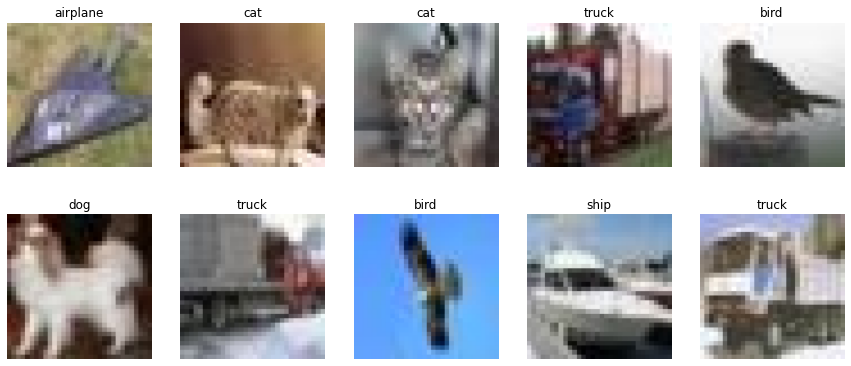

In [ ]:
target_labels = next(os.walk(directory_train))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [ ]:
feature_extractor = tf.keras.applications.Xception(weights="imagenet")

In [ ]:
def remove_head(feature_extractor_model):
    model_input = feature_extractor_model.input
    output = feature_extractor_model.get_layer(name='avg_pool').output
    model = tf.keras.Model(inputs=model_input, outputs=output)
    return model

In [ ]:
feature_extractor = remove_head(feature_extractor)
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
def add_new_classifier_head(feature_extractor_model):
    model = Sequential([
        feature_extractor_model,
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(target_labels.shape[0], activation='softmax')
    ])
    
    return model   

In [ ]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 21,125,042
Trainable params: 21,070,514
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
def freeze_pretrained_weights(model):
    model.get_layer(name='model').trainable=False
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 21,125,042
Trainable params: 263,562
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen)
    
    return history

In [ ]:
history_frozen_new_model = train_model(frozen_new_model, train_generator, validation_generator,10)

Epoch 1/10
1250/1250 [==============================] - 192s 154ms/step - loss: 0.7455 - accuracy: 0.7442 - val_loss: 0.6695 - val_accuracy: 0.7660
Epoch 2/10
1250/1250 [==============================] - 194s 156ms/step - loss: 0.6897 - accuracy: 0.7631 - val_loss: 0.6485 - val_accuracy: 0.7741
Epoch 3/10
1250/1250 [==============================] - 195s 156ms/step - loss: 0.6562 - accuracy: 0.7703 - val_loss: 0.6349 - val_accuracy: 0.7780
Epoch 4/10
1250/1250 [==============================] - 189s 151ms/step - loss: 0.6280 - accuracy: 0.7818 - val_loss: 0.6413 - val_accuracy: 0.7755
Epoch 5/10
1250/1250 [==============================] - 191s 153ms/step - loss: 0.6056 - accuracy: 0.7897 - val_loss: 0.6572 - val_accuracy: 0.7750
Epoch 6/10
1250/1250 [==============================] - 186s 149ms/step - loss: 0.5825 - accuracy: 0.7955 - val_loss: 0.6403 - val_accuracy: 0.7805
Epoch 7/10
1250/1250 [==============================] - 195s 156ms/step - loss: 0.5597 - accuracy: 0.8022 - val_

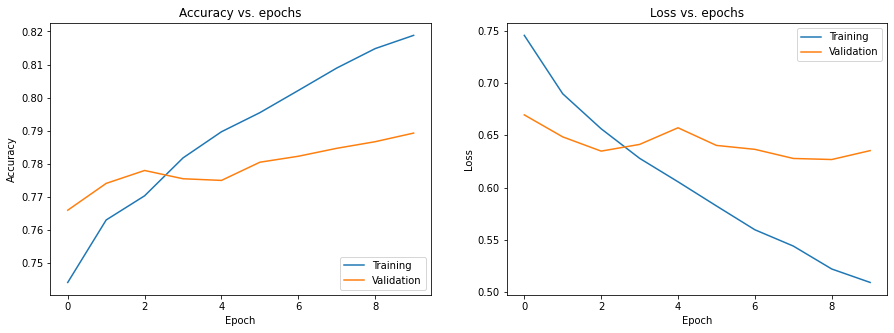

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_new_model.history['accuracy'])
plt.plot(history_frozen_new_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
test_steps = test_generator.n // test_generator.batch_size
benchmark_test_loss, benchmark_test_acc = frozen_new_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset:')
print("Loss: {}".format(benchmark_test_loss))
print("Accuracy: {}".format(benchmark_test_acc))

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [ ]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(test_generator, steps=50)
print('\nTest dataset')

In [ ]:
test_generator= get_generator(image_gen_test, 
    directory_test = "/content/drive/MyDrive/멀티캠퍼스/data/test/test1/",
    target_size=20, class_mode='catecorical'
)
test_loss, test_acc=new_model.evaluate_generator(test_generator,steps=50)
print('test acc:', test_acc)